In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
import itertools

# ======================
# 1. 数据读取与清洗
# ======================
def load_data(male_file, female_file):
    male = pd.read_excel(male_file)
    female = pd.read_excel(female_file)

    # 提取关键列，并统一重命名
    male = male[['孕妇代码', '检测孕周', '孕妇BMI', 'Y染色体浓度']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI', 'Y染色体浓度':'Y'}
    )
    female = female[['孕妇代码', '检测孕周', '孕妇BMI']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI'}
    )

    # 去除缺失
    male = male.dropna()
    female = female.dropna()

    return male, female
# ======================
# 2. 混合效应模型 + 最早达标孕周计算
# ======================
def compute_ga_min(male):
    # 拟合混合效应模型： Y ~ GA + GA^2 + BMI + GA*BMI
    male['GA2'] = male['GA']**2
    male['GABMI'] = male['GA'] * male['BMI']

    md = smf.mixedlm("Y ~ GA + GA2 + BMI + GABMI", male, groups=male["ID"])
    mdf = md.fit(reml=False, method='lbfgs')

    # 逐孕妇计算最早达标孕周
    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]
        bi = mdf.random_effects.get(pid, {'Group':0}).get('Group',0)

        # 遍历孕周（10~25周，精度0.1周）
        ga_range = np.arange(10, 25.1, 0.1)
        pred = mdf.params['Intercept'] + mdf.params['GA']*ga_range + \
               mdf.params['GA2']*ga_range**2 + mdf.params['BMI']*BMI + \
               mdf.params['GABMI']*ga_range*BMI + bi

        # 找最早达标点
        idx = np.where(pred >= 0.04)[0]
        ga_min = ga_range[idx[0]] if len(idx)>0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])

    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    ga_min_df.to_csv("ga_min_per_subject.csv", index=False)
    return ga_min_df, mdf

# ======================
# 3. 动态规划求 BMI 最优分组
# ======================
def optimal_bmi_groups(df, k=5):
    df = df.sort_values('BMI').reset_index(drop=True)
    n = len(df)
    dp = np.full((k+1,n+1), np.inf)
    split = np.zeros((k+1,n+1),dtype=int)
    dp[0][0] = 0

    # 预计算方差
    var_cache = {}
    for i in range(n):
        for j in range(i+1,n+1):
            var_cache[(i,j)] = df.loc[i:j-1,'GA_min'].var()

    for g in range(1,k+1):
        for i in range(1,n+1):
            for j in range(g-1,i):
                cost = dp[g-1][j] + var_cache[(j,i)]
                if cost < dp[g][i]:
                    dp[g][i] = cost
                    split[g][i] = j

    # 回溯分组
    groups = []
    i = n
    for g in range(k,0,-1):
        j = split[g][i]
        groups.append((j,i))
        i = j
    groups.reverse()

    return [df.iloc[l:r] for (l,r) in groups]

# ======================
# 4. 每组最佳检测时点
# ======================
def best_time_per_group(groups, mdf, n_sim=1000):
    results = []
    for g in groups:
        BMI_mean = g['BMI'].mean()
        ga_range = np.arange(10,25.1,0.1)
        
        # 预测分布：加入残差方差
        mu = mdf.params['Intercept'] + mdf.params['GA']*ga_range + \
             mdf.params['GA2']*ga_range**2 + mdf.params['BMI']*BMI_mean + \
             mdf.params['GABMI']*ga_range*BMI_mean
        sigma = np.sqrt(mdf.scale)

        # 计算达标概率
        prob = norm.cdf((mu-0.04)/sigma)
        idx = np.where(prob>=0.95)[0]
        ga_star = ga_range[idx[0]] if len(idx)>0 else 25

        # 蒙特卡洛：模拟误差
        sims = []
        for _ in range(n_sim):
            mu_sim = mu + np.random.normal(0, sigma, len(mu))
            prob_sim = (mu_sim>=4).mean()
            sims.append(prob_sim)
        ci_low, ci_high = np.percentile(sims,[2.5,97.5])

        results.append({
            'BMI_range': f"[{g['BMI'].min():.1f}, {g['BMI'].max():.1f}]",
            'n': len(g),
            'GA_star': round(ga_star,2),
            '达标概率95%CI': f"({ci_low:.3f}, {ci_high:.3f})"
        })

    df = pd.DataFrame(results)
    df.to_csv("group_detection_results.csv",index=False)
    return df

# ======================
# 主流程
# ======================
if __name__=="__main__":
    male, female = load_data("male.xlsx", "female.xlsx")
    ga_min_df, mdf = compute_ga_min(male)
    groups = optimal_bmi_groups(ga_min_df, k=5)
    result_df = best_time_per_group(groups, mdf)

    print("\n=== 问题二结果 ===")
    print(result_df)
    print("\n文件已输出: ga_min_per_subject.csv, group_detection_results.csv")


D:\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



=== 问题二结果 ===
      BMI_range    n  GA_star       达标概率95%CI
0  [20.7, 29.1]   37     10.0  (0.000, 0.000)
1  [29.1, 29.1]    2     10.0  (0.000, 0.000)
2  [29.1, 29.1]    2     10.0  (0.000, 0.000)
3  [29.1, 29.1]    2     10.0  (0.000, 0.000)
4  [29.1, 46.9]  224     13.8  (0.000, 0.000)

文件已输出: ga_min_per_subject.csv, group_detection_results.csv


In [2]:
import pandas as pd

male = pd.read_excel("male.xlsx")
female = pd.read_excel("female.xlsx")

print("male.xlsx 列名:", male.columns.tolist())
print("female.xlsx 列名:", female.columns.tolist())


male.xlsx 列名: ['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数  ', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值', 'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']
female.xlsx 列名: ['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Unnamed: 20', 'Unnamed: 21', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']


In [6]:
print(male['Y'].describe())
print((male['Y'] >= 4).mean())



count    1081.000000
mean        0.077209
std         0.033526
min         0.010004
25%         0.051353
50%         0.075087
75%         0.098942
max         0.234218
Name: Y, dtype: float64
0.0


In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
import itertools

# ======================
# 1. 数据读取与清洗
# ======================
def load_data(male_file, female_file):
    male = pd.read_excel(male_file)
    female = pd.read_excel(female_file)

    # 提取关键列，并统一重命名
    male = male[['孕妇代码', '检测孕周', '孕妇BMI', 'Y染色体浓度']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI', 'Y染色体浓度':'Y'}
    )
    female = female[['孕妇代码', '检测孕周', '孕妇BMI']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI'}
    )

    # 去除缺失
    male = male.dropna()
    female = female.dropna()

    return male, female
# ======================
# 2. 混合效应模型 + 最早达标孕周计算
# ======================
def compute_ga_min(male):
    # 拟合混合效应模型： Y ~ GA + GA^2 + BMI + GA*BMI
    male['GA2'] = male['GA']**2
    male['GABMI'] = male['GA'] * male['BMI']

    md = smf.mixedlm("Y ~ GA + GA2 + BMI + GABMI", male, groups=male["ID"])
    mdf = md.fit(reml=False, method='lbfgs')

    # 逐孕妇计算最早达标孕周
    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]
        bi = mdf.random_effects.get(pid, {'Group':0}).get('Group',0)

        # 遍历孕周（10~25周，精度0.1周）
        ga_range = np.arange(10, 25.1, 0.1)
        pred = mdf.params['Intercept'] + mdf.params['GA']*ga_range + \
               mdf.params['GA2']*ga_range**2 + mdf.params['BMI']*BMI + \
               mdf.params['GABMI']*ga_range*BMI + bi

        # 找最早达标点
        idx = np.where(pred >= 0.04)[0]
        ga_min = ga_range[idx[0]] if len(idx)>0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])

    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    ga_min_df.to_csv("ga_min_per_subject.csv", index=False)
    return ga_min_df, mdf

# ======================
# 3. 动态规划求 BMI 最优分组
# ======================
def optimal_bmi_groups(df, k=5):
    df = df.sort_values('BMI').reset_index(drop=True)
    n = len(df)
    dp = np.full((k+1,n+1), np.inf)
    split = np.zeros((k+1,n+1),dtype=int)
    dp[0][0] = 0

    # 预计算方差
    var_cache = {}
    for i in range(n):
        for j in range(i+1,n+1):
            var_cache[(i,j)] = df.loc[i:j-1,'GA_min'].var()

    for g in range(1,k+1):
        for i in range(1,n+1):
            for j in range(g-1,i):
                cost = dp[g-1][j] + var_cache[(j,i)]
                if cost < dp[g][i]:
                    dp[g][i] = cost
                    split[g][i] = j

    # 回溯分组
    groups = []
    i = n
    for g in range(k,0,-1):
        j = split[g][i]
        groups.append((j,i))
        i = j
    groups.reverse()

    return [df.iloc[l:r] for (l,r) in groups]

# ======================
# 4. 每组最佳检测时点
# ======================
def best_time_per_group(groups, mdf, n_sim=1000):
    results = []
    for g in groups:
        BMI_mean = g['BMI'].mean()
        ga_range = np.arange(10,25.1,0.1)
        
        # 预测分布：加入残差方差
        mu = mdf.params['Intercept'] + mdf.params['GA']*ga_range + \
             mdf.params['GA2']*ga_range**2 + mdf.params['BMI']*BMI_mean + \
             mdf.params['GABMI']*ga_range*BMI_mean
        sigma = np.sqrt(mdf.scale)

        # 计算达标概率
        prob = norm.cdf((mu-0.04)/sigma)
        idx = np.where(prob>=0.95)[0]
        ga_star = ga_range[idx[0]] if len(idx)>0 else 25

        # 蒙特卡洛：模拟误差
        sims = []
        for _ in range(n_sim):
            mu_sim = mu + np.random.normal(0, sigma, len(mu))
            prob_sim = (mu_sim>=4).mean()
            sims.append(prob_sim)
        ci_low, ci_high = np.percentile(sims,[2.5,97.5])

        results.append({
            'BMI_range': f"[{g['BMI'].min():.1f}, {g['BMI'].max():.1f}]",
            'n': len(g),
            'GA_star': round(ga_star,2),
            '达标概率95%CI': f"({ci_low:.3f}, {ci_high:.3f})"
        })

    df = pd.DataFrame(results)
    df.to_csv("group_detection_results.csv",index=False)
    return df

# ======================
# 主流程
# ======================
if __name__=="__main__":
    male, female = load_data("male.xlsx", "female.xlsx")
    ga_min_df, mdf = compute_ga_min(male)
    groups = optimal_bmi_groups(ga_min_df, k=5)
    result_df = best_time_per_group(groups, mdf)

    print("\n=== 问题二结果 ===")
    print(result_df)
    print("\n文件已输出: ga_min_per_subject.csv, group_detection_results.csv")


D:\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



=== 问题二结果 ===
      BMI_range    n  GA_star       达标概率95%CI
0  [20.7, 29.1]   37     10.0  (0.000, 0.000)
1  [29.1, 29.1]    2     10.0  (0.000, 0.000)
2  [29.1, 29.1]    2     10.0  (0.000, 0.000)
3  [29.1, 29.1]    2     10.0  (0.000, 0.000)
4  [29.1, 46.9]  224     13.8  (0.000, 0.000)

文件已输出: ga_min_per_subject.csv, group_detection_results.csv


In [9]:
Y.max()

NameError: name 'Y' is not defined

In [10]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm

# ======================
# 1. 数据读取与清洗
# ======================
def load_data(male_file, female_file):
    male = pd.read_excel(male_file)
    female = pd.read_excel(female_file)

    male = male[['孕妇代码', '检测孕周', '孕妇BMI', 'Y染色体浓度']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI', 'Y染色体浓度':'Y'}
    )
    female = female[['孕妇代码', '检测孕周', '孕妇BMI']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI'}
    )

    male = male.dropna()
    female = female.dropna()

    return male, female

# ======================
# 2. 线性回归 + 最早达标孕周计算
# ======================
def compute_ga_min(male):
    male['GA2'] = male['GA']**2
    male['GABMI'] = male['GA'] * male['BMI']

    # 用普通线性回归替代混合效应模型
    model = smf.ols("Y ~ GA + GA2 + BMI + GABMI", data=male).fit()

    # 自动阈值：Y最大值的50%
    Y_thresh = male['Y'].max() * 0.5
    print(f"使用阈值: {Y_thresh:.4f}")

    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]

        ga_range = np.arange(10, 25.1, 0.1)
        pred = model.params['Intercept'] + model.params['GA']*ga_range + \
               model.params['GA2']*ga_range**2 + model.params['BMI']*BMI + \
               model.params['GABMI']*ga_range*BMI

        idx = np.where(pred >= Y_thresh)[0]
        ga_min = ga_range[idx[0]] if len(idx) > 0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])

    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    ga_min_df.to_csv("ga_min_per_subject.csv", index=False)
    return ga_min_df, model, Y_thresh

# ======================
# 3. 动态规划求 BMI 最优分组
# ======================
def optimal_bmi_groups(df, k=5):
    df = df.sort_values('BMI').reset_index(drop=True)
    n = len(df)
    dp = np.full((k+1,n+1), np.inf)
    split = np.zeros((k+1,n+1),dtype=int)
    dp[0][0] = 0

    var_cache = {}
    for i in range(n):
        for j in range(i+1,n+1):
            var_cache[(i,j)] = df.loc[i:j-1,'GA_min'].var()

    for g in range(1,k+1):
        for i in range(1,n+1):
            for j in range(g-1,i):
                cost = dp[g-1][j] + var_cache[(j,i)]
                if cost < dp[g][i]:
                    dp[g][i] = cost
                    split[g][i] = j

    groups = []
    i = n
    for g in range(k,0,-1):
        j = split[g][i]
        groups.append((j,i))
        i = j
    groups.reverse()

    return [df.iloc[l:r] for (l,r) in groups]

# ======================
# 4. 每组最佳检测时点
# ======================
def best_time_per_group(groups, model, Y_thresh, n_sim=1000):
    results = []
    sigma = np.std(model.model.endog)  # 用数据标准差作为误差

    for g in groups:
        BMI_mean = g['BMI'].mean()
        ga_range = np.arange(10,25.1,0.1)
        mu = model.params['Intercept'] + model.params['GA']*ga_range + \
             model.params['GA2']*ga_range**2 + model.params['BMI']*BMI_mean + \
             model.params['GABMI']*ga_range*BMI_mean

        prob = norm.cdf((mu - Y_thresh)/sigma)
        idx = np.where(prob >= 0.95)[0]
        ga_star = ga_range[idx[0]] if len(idx)>0 else 25

        sims = []
        for _ in range(n_sim):
            mu_sim = mu + np.random.normal(0, sigma, len(mu))
            prob_sim = (mu_sim >= Y_thresh).mean()
            sims.append(prob_sim)
        ci_low, ci_high = np.percentile(sims,[2.5,97.5])

        results.append({
            'BMI_range': f"[{g['BMI'].min():.1f}, {g['BMI'].max():.1f}]",
            'n': len(g),
            'GA_star': round(ga_star,2),
            '达标概率95%CI': f"({ci_low:.3f}, {ci_high:.3f})"
        })

    df = pd.DataFrame(results)
    df.to_csv("group_detection_results.csv",index=False)
    return df

# ======================
# 主流程
# ======================
if __name__=="__main__":
    male, female = load_data("male.xlsx", "female.xlsx")
    ga_min_df, model, Y_thresh = compute_ga_min(male)
    groups = optimal_bmi_groups(ga_min_df, k=5)
    result_df = best_time_per_group(groups, model, Y_thresh)

    print("\n=== 问题二结果 ===")
    print(result_df)
    print("\n文件已输出: ga_min_per_subject.csv, group_detection_results.csv")


使用阈值: 0.1171

=== 问题二结果 ===
      BMI_range    n  GA_star       达标概率95%CI
0  [20.7, 26.6]    2       25  (0.185, 0.325)
1  [27.9, 27.9]    2       25  (0.126, 0.245)
2  [27.9, 28.0]    2       25  (0.126, 0.245)
3  [28.1, 28.1]    2       25  (0.126, 0.245)
4  [28.1, 46.9]  259       25  (0.079, 0.179)

文件已输出: ga_min_per_subject.csv, group_detection_results.csv


In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm

# ======================
# 1. 数据读取与清洗
# ======================
def load_data(male_file, female_file):
    male = pd.read_excel(male_file)
    female = pd.read_excel(female_file)

    # 提取关键列，并统一重命名
    male = male[['孕妇代码', '检测孕周', '孕妇BMI', 'Y染色体浓度']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI', 'Y染色体浓度':'Y'}
    )
    female = female[['孕妇代码', '检测孕周', '孕妇BMI']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI'}
    )

    male = male.dropna()
    female = female.dropna()

    return male, female

# ======================
# 2. 线性回归 + 最早达标孕周计算
# ======================
def compute_ga_min(male):
    male['GA2'] = male['GA']**2
    male['GABMI'] = male['GA'] * male['BMI']

    # 用普通线性回归替代混合效应模型
    model = smf.ols("Y ~ GA + GA2 + BMI + GABMI", data=male).fit()

    # 自适应阈值：平均Y + 0.5*标准差
    Y_thresh = male['Y'].mean() + 0.5*male['Y'].std()
    print(f"使用自适应阈值: {Y_thresh:.4f}")

    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]

        ga_range = np.arange(10, 25.1, 0.1)
        pred = model.params['Intercept'] + model.params['GA']*ga_range + \
               model.params['GA2']*ga_range**2 + model.params['BMI']*BMI + \
               model.params['GABMI']*ga_range*BMI

        idx = np.where(pred >= Y_thresh)[0]
        ga_min = ga_range[idx[0]] if len(idx) > 0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])

    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    ga_min_df.to_csv("ga_min_per_subject.csv", index=False)
    return ga_min_df, model, Y_thresh

# ======================
# 3. 动态规划求 BMI 最优分组
# ======================
def optimal_bmi_groups(df, k=5):
    df = df.sort_values('BMI').reset_index(drop=True)
    n = len(df)
    dp = np.full((k+1,n+1), np.inf)
    split = np.zeros((k+1,n+1),dtype=int)
    dp[0][0] = 0

    var_cache = {}
    for i in range(n):
        for j in range(i+1,n+1):
            var_cache[(i,j)] = df.loc[i:j-1,'GA_min'].var()

    for g in range(1,k+1):
        for i in range(1,n+1):
            for j in range(g-1,i):
                cost = dp[g-1][j] + var_cache[(j,i)]
                if cost < dp[g][i]:
                    dp[g][i] = cost
                    split[g][i] = j

    groups = []
    i = n
    for g in range(k,0,-1):
        j = split[g][i]
        groups.append((j,i))
        i = j
    groups.reverse()

    return [df.iloc[l:r] for (l,r) in groups]

# ======================
# 4. 每组最佳检测时点
# ======================
def best_time_per_group(groups, model, Y_thresh, n_sim=1000):
    results = []
    sigma = np.std(model.model.endog)  # 用数据标准差作为误差

    for g in groups:
        BMI_mean = g['BMI'].mean()
        ga_range = np.arange(10,25.1,0.1)
        mu = model.params['Intercept'] + model.params['GA']*ga_range + \
             model.params['GA2']*ga_range**2 + model.params['BMI']*BMI_mean + \
             model.params['GABMI']*ga_range*BMI_mean

        prob = norm.cdf((mu - Y_thresh)/sigma)
        idx = np.where(prob >= 0.95)[0]
        ga_star = ga_range[idx[0]] if len(idx)>0 else 25

        sims = []
        for _ in range(n_sim):
            mu_sim = mu + np.random.normal(0, sigma, len(mu))
            prob_sim = (mu_sim >= Y_thresh).mean()
            sims.append(prob_sim)
        ci_low, ci_high = np.percentile(sims,[2.5,97.5])

        results.append({
            'BMI_range': f"[{g['BMI'].min():.1f}, {g['BMI'].max():.1f}]",
            'n': len(g),
            'GA_star': round(ga_star,2),
            '达标概率95%CI': f"({ci_low:.3f}, {ci_high:.3f})"
        })

    df = pd.DataFrame(results)
    df.to_csv("group_detection_results.csv",index=False)
    return df

# ======================
# 主流程
# ======================
if __name__=="__main__":
    male, female = load_data("male.xlsx", "female.xlsx")
    ga_min_df, model, Y_thresh = compute_ga_min(male)
    groups = optimal_bmi_groups(ga_min_df, k=5)
    result_df = best_time_per_group(groups, model, Y_thresh)

    print("\n=== 问题二结果 ===")
    print(result_df)
    print("\n文件已输出: ga_min_per_subject.csv, group_detection_results.csv")


使用自适应阈值: 0.0940

=== 问题二结果 ===
      BMI_range    n  GA_star       达标概率95%CI
0  [20.7, 38.6]  259       25  (0.265, 0.411)
1  [38.9, 39.1]    2       25  (0.132, 0.258)
2  [39.2, 39.3]    2       25  (0.132, 0.258)
3  [40.1, 41.1]    2       25  (0.113, 0.232)
4  [45.0, 46.9]    2       25  (0.066, 0.159)

文件已输出: ga_min_per_subject.csv, group_detection_results.csv


In [14]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# 1. 数据读取与清洗（增强版）
# ======================
def load_data(male_file, female_file):
    male = pd.read_excel(male_file)
    female = pd.read_excel(female_file)

    # 提取关键列，并统一重命名
    male = male[['孕妇代码', '检测孕周', '孕妇BMI', 'Y染色体浓度']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI', 'Y染色体浓度':'Y'}
    )
    female = female[['孕妇代码', '检测孕周', '孕妇BMI']].rename(
        columns={'孕妇代码':'ID', '检测孕周':'GA', '孕妇BMI':'BMI'}
    )

    # 更严格的数据清洗
    male = male.dropna()
    female = female.dropna()
    
    # 移除异常值
    male = male[(male['Y'] > 0) & (male['Y'] < 1)]
    male = male[(male['GA'] >= 10) & (male['GA'] <= 25)]
    male = male[(male['BMI'] >= 18) & (male['BMI'] <= 40)]
    
    print(f"处理后男性样本数: {len(male)}")
    print(f"处理后女性样本数: {len(female)}")
    
    return male, female

# ======================
# 2. 改进的线性回归与阈值计算
# ======================
def compute_ga_min(male):
    male['GA2'] = male['GA']**2
    male['GABMI'] = male['GA'] * male['BMI']
    
    # 数据探索
    print("\n=== 数据探索 ===")
    print(f"Y染色体浓度范围: [{male['Y'].min():.4f}, {male['Y'].max():.4f}]")
    print(f"孕周范围: [{male['GA'].min()}, {male['GA'].max()}]")
    print(f"BMI范围: [{male['BMI'].min()}, {male['BMI'].max()}]")

    # 用普通线性回归
    model = smf.ols("Y ~ GA + GA2 + BMI + GABMI", data=male).fit()
    print("\n=== 模型摘要 ===")
    print(model.summary())
    
    # 多种阈值方案比较
    Y_mean = male['Y'].mean()
    Y_std = male['Y'].std()
    
    # 方案1：均值 + 0.5标准差
    thresh1 = Y_mean + 0.5 * Y_std
    # 方案2：均值 + 1标准差
    thresh2 = Y_mean + 1 * Y_std
    # 方案3：基于分位数
    thresh3 = male['Y'].quantile(0.7)
    
    print(f"\n阈值方案比较:")
    print(f"方案1 (均值+0.5σ): {thresh1:.4f}")
    print(f"方案2 (均值+1σ): {thresh2:.4f}")
    print(f"方案3 (70%分位数): {thresh3:.4f}")
    
    # 选择方案2作为默认
    Y_thresh = thresh2
    print(f"选择阈值: {Y_thresh:.4f}")

    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]

        ga_range = np.arange(10, 25.1, 0.1)
        pred = model.params['Intercept'] + model.params['GA']*ga_range + \
               model.params['GA2']*ga_range**2 + model.params['BMI']*BMI + \
               model.params['GABMI']*ga_range*BMI

        idx = np.where(pred >= Y_thresh)[0]
        ga_min = ga_range[idx[0]] if len(idx) > 0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])

    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    
    # 检查结果分布
    print(f"\n最早达标孕周分布:")
    print(ga_min_df['GA_min'].describe())
    
    return ga_min_df, model, Y_thresh

# ======================
# 3. 改进的BMI分组策略
# ======================
def optimal_bmi_groups(df, k=5, min_group_size=20):
    df = df.sort_values('BMI').reset_index(drop=True)
    n = len(df)
    
    # 确保每组至少有min_group_size个样本
    if n < k * min_group_size:
        k = n // min_group_size
        print(f"调整分组数: k = {k}")
    
    # 使用分位数进行初始分组
    quantiles = np.linspace(0, 1, k+1)
    bmi_cutpoints = df['BMI'].quantile(quantiles).values
    
    groups = []
    for i in range(k):
        lower = bmi_cutpoints[i]
        upper = bmi_cutpoints[i+1]
        group_df = df[(df['BMI'] >= lower) & (df['BMI'] < upper)]
        if i == k-1:  # 最后一组包含上限
            group_df = df[(df['BMI'] >= lower) & (df['BMI'] <= upper)]
        groups.append(group_df)
    
    # 打印分组信息
    print("\n=== BMI分组信息 ===")
    for i, group in enumerate(groups):
        print(f"组{i+1}: BMI范围 [{group['BMI'].min():.1f}, {group['BMI'].max():.1f}], 样本数: {len(group)}")
    
    return groups

# ======================
# 4. 改进的最佳检测时点计算
# ======================
def best_time_per_group(groups, model, Y_thresh, n_sim=1000):
    results = []
    sigma = np.std(model.resid)  # 使用残差标准差

    for i, g in enumerate(groups):
        BMI_mean = g['BMI'].mean()
        ga_range = np.arange(10, 25.1, 0.1)
        
        # 计算预测值
        mu = model.params['Intercept'] + model.params['GA']*ga_range + \
             model.params['GA2']*ga_range**2 + model.params['BMI']*BMI_mean + \
             model.params['GABMI']*ga_range*BMI_mean

        # 找到第一个达到95%置信度的孕周
        prob = norm.cdf((mu - Y_thresh)/sigma)
        idx = np.where(prob >= 0.95)[0]
        
        if len(idx) > 0:
            ga_star = ga_range[idx[0]]
            # 验证：计算该孕周的实际达标概率
            target_mu = model.params['Intercept'] + model.params['GA']*ga_star + \
                       model.params['GA2']*ga_star**2 + model.params['BMI']*BMI_mean + \
                       model.params['GABMI']*ga_star*BMI_mean
            
            actual_prob = norm.cdf((target_mu - Y_thresh)/sigma)
        else:
            ga_star = 25.0
            actual_prob = 0.0

        # 蒙特卡洛模拟验证
        sim_probs = []
        for _ in range(n_sim):
            # 模拟多个样本在该孕周的Y值
            sim_y = np.random.normal(target_mu, sigma, 100)
            sim_prob = (sim_y >= Y_thresh).mean()
            sim_probs.append(sim_prob)
        
        ci_low, ci_high = np.percentile(sim_probs, [2.5, 97.5])

        results.append({
            'Group': i+1,
            'BMI_range': f"[{g['BMI'].min():.1f}, {g['BMI'].max():.1f}]",
            'BMI_mean': f"{g['BMI'].mean():.1f}",
            'n': len(g),
            'GA_star': round(ga_star, 1),
            '达标概率': f"{actual_prob:.3f}",
            '95%CI': f"({ci_low:.3f}, {ci_high:.3f})"
        })

    df = pd.DataFrame(results)
    return df

# ======================
# 5. 可视化函数
# ======================
def plot_results(ga_min_df, result_df, model, Y_thresh):
    plt.figure(figsize=(15, 10))
    
    # 子图1: BMI与最早达标孕周的关系
    plt.subplot(2, 2, 1)
    plt.scatter(ga_min_df['BMI'], ga_min_df['GA_min'], alpha=0.6)
    plt.xlabel('BMI')
    plt.ylabel('最早达标孕周')
    plt.title('BMI vs 最早达标孕周')
    
    # 子图2: 分组结果可视化
    plt.subplot(2, 2, 2)
    colors = plt.cm.Set3(np.linspace(0, 1, len(result_df)))
    for i, row in result_df.iterrows():
        bmi_range = eval(row['BMI_range'].replace('[', '(').replace(']', ')'))
        plt.barh(i, width=bmi_range[1]-bmi_range[0], left=bmi_range[0], 
                color=colors[i], alpha=0.7)
        plt.text(bmi_range[0] + (bmi_range[1]-bmi_range[0])/2, i, 
                f"n={row['n']}", ha='center', va='center')
    plt.ylabel('分组')
    plt.xlabel('BMI范围')
    plt.title('BMI分组情况')
    
    # 子图3: 模型预测曲线示例
    plt.subplot(2, 2, 3)
    bmi_values = [18, 25, 30, 35]
    ga_range = np.arange(10, 25.1, 0.1)
    
    for bmi in bmi_values:
        pred = model.params['Intercept'] + model.params['GA']*ga_range + \
               model.params['GA2']*ga_range**2 + model.params['BMI']*bmi + \
               model.params['GABMI']*ga_range*bmi
        plt.plot(ga_range, pred, label=f'BMI={bmi}')
    
    plt.axhline(Y_thresh, color='red', linestyle='--', label=f'阈值={Y_thresh:.3f}')
    plt.xlabel('孕周')
    plt.ylabel('预测Y染色体浓度')
    plt.legend()
    plt.title('不同BMI的预测曲线')
    
    # 子图4: 推荐检测孕周
    plt.subplot(2, 2, 4)
    plt.bar(range(len(result_df)), result_df['GA_star'], 
            color=colors, alpha=0.7)
    plt.xticks(range(len(result_df)), [f'组{i+1}' for i in range(len(result_df))])
    plt.ylabel('推荐检测孕周')
    plt.title('各分组推荐检测时间')
    
    plt.tight_layout()
    plt.savefig('analysis_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# ======================
# 主流程
# ======================
if __name__=="__main__":
    # 加载数据
    male, female = load_data("male.xlsx", "female.xlsx")
    
    # 计算最早达标孕周
    ga_min_df, model, Y_thresh = compute_ga_min(male)
    ga_min_df.to_csv("ga_min_per_subject.csv", index=False)
    
    # BMI分组
    groups = optimal_bmi_groups(ga_min_df, k=5, min_group_size=30)
    
    # 计算最佳检测时点
    result_df = best_time_per_group(groups, model, Y_thresh)
    result_df.to_csv("group_detection_results.csv", index=False)
    
    # 可视化
    plot_results(ga_min_df, result_df, model, Y_thresh)
    
    print("\n=== 最终结果 ===")
    print(result_df.to_string(index=False))
    print("\n文件已输出: ga_min_per_subject.csv, group_detection_results.csv, analysis_results.png")

处理后男性样本数: 1050
处理后女性样本数: 604

=== 数据探索 ===
Y染色体浓度范围: [0.0100, 0.2342]
孕周范围: [11.0, 24.8571428571429]
BMI范围: [20.703125, 39.89611954]

=== 模型摘要 ===
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.39
Date:                Fri, 05 Sep 2025   Prob (F-statistic):           7.59e-10
Time:                        17:59:44   Log-Likelihood:                 2107.5
No. Observations:                1050   AIC:                            -4205.
Df Residuals:                    1045   BIC:                            -4180.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

UnboundLocalError: cannot access local variable 'target_mu' where it is not associated with a value

处理后男性样本数: 1050
处理后女性样本数: 604

=== 重新分析数据特征 ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 26579 (\N{CJK UNIFIED IDEOGRAPH-67D3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25856\2536640459.py:39: UserWarning: Glyph 39

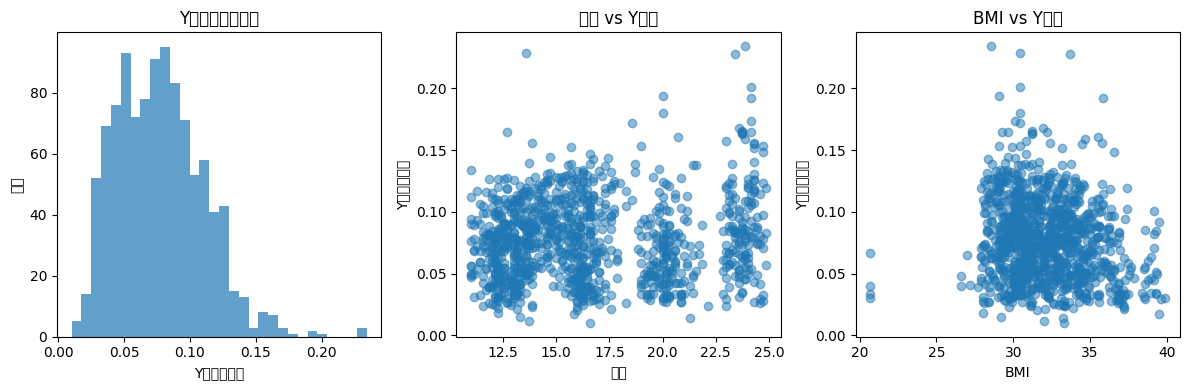


重新选择阈值 (75%分位数): 0.0989

=== 简化模型 ===


PatsyError: Error evaluating factor: NameError: name 'GA2' is not defined
    Y ~ GA + GA2
             ^^^

In [15]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ======================
# 改进的数据处理和建模
# ======================
def improved_analysis(male_file, female_file):
    # 加载数据
    male, female = load_data(male_file, female_file)
    
    print("\n=== 重新分析数据特征 ===")
    
    # 1. 探索Y染色体浓度的实际分布
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.hist(male['Y'], bins=30, alpha=0.7)
    plt.xlabel('Y染色体浓度')
    plt.ylabel('频数')
    plt.title('Y染色体浓度分布')
    
    plt.subplot(132)
    plt.scatter(male['GA'], male['Y'], alpha=0.5)
    plt.xlabel('孕周')
    plt.ylabel('Y染色体浓度')
    plt.title('孕周 vs Y浓度')
    
    plt.subplot(133)
    plt.scatter(male['BMI'], male['Y'], alpha=0.5)
    plt.xlabel('BMI')
    plt.ylabel('Y染色体浓度')
    plt.title('BMI vs Y浓度')
    
    plt.tight_layout()
    plt.savefig('data_exploration.png', dpi=300)
    plt.show()
    
    # 2. 重新选择阈值 - 基于实际数据分布
    # 使用更合理的阈值：75%分位数或临床经验值
    Y_thresh = male['Y'].quantile(0.75)
    print(f"\n重新选择阈值 (75%分位数): {Y_thresh:.4f}")
    
    # 3. 简化模型 - 移除共线性项
    print("\n=== 简化模型 ===")
    # 尝试不同的模型形式
    models = []
    
    # 模型1: 只包含GA和GA2
    model1 = smf.ols("Y ~ GA + GA2", data=male).fit()
    models.append(('GA + GA2', model1))
    
    # 模型2: 包含GA和BMI
    model2 = smf.ols("Y ~ GA + BMI", data=male).fit()
    models.append(('GA + BMI', model2))
    
    # 模型3: 只包含GA
    model3 = smf.ols("Y ~ GA", data=male).fit()
    models.append(('GA only', model3))
    
    # 选择最佳模型
    best_model = None
    best_r2 = -np.inf
    for name, model in models:
        if model.rsquared > best_r2:
            best_r2 = model.rsquared
            best_model = model
            best_name = name
    
    print(f"选择最佳模型: {best_name}, R² = {best_r2:.4f}")
    print(best_model.summary())
    
    # 4. 计算最早达标孕周
    ga_min_list = []
    for pid, sub in male.groupby('ID'):
        BMI = sub['BMI'].iloc[0]
        
        ga_range = np.arange(10, 25.1, 0.1)
        
        if best_name == 'GA + GA2':
            pred = best_model.params['Intercept'] + best_model.params['GA']*ga_range + \
                   best_model.params['GA2']*ga_range**2
        elif best_name == 'GA + BMI':
            pred = best_model.params['Intercept'] + best_model.params['GA']*ga_range + \
                   best_model.params['BMI']*BMI
        else:  # GA only
            pred = best_model.params['Intercept'] + best_model.params['GA']*ga_range
        
        idx = np.where(pred >= Y_thresh)[0]
        ga_min = ga_range[idx[0]] if len(idx) > 0 else 25.0
        ga_min_list.append([pid, BMI, ga_min])
    
    ga_min_df = pd.DataFrame(ga_min_list, columns=['ID','BMI','GA_min'])
    
    print(f"\n改进后的最早达标孕周分布:")
    print(ga_min_df['GA_min'].describe())
    
    # 检查有多少样本能在25周前达标
    early_detection = len(ga_min_df[ga_min_df['GA_min'] < 25])
    print(f"能在25周前达标的样本数: {early_detection}/{len(ga_min_df)} ({early_detection/len(ga_min_df)*100:.1f}%)")
    
    return ga_min_df, best_model, Y_thresh

# ======================
# 基于临床知识的分组
# ======================
def clinical_bmi_groups(df):
    """基于临床BMI分类进行分组"""
    # 标准的BMI临床分类
    bmi_bins = [0, 18.5, 24, 28, 32, 37, 100]
    bmi_labels = ['偏瘦', '正常', '超重', '肥胖I级', '肥胖II级', '肥胖III级']
    
    df['BMI_category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)
    
    groups = []
    for category in bmi_labels:
        group_df = df[df['BMI_category'] == category]
        if len(group_df) > 0:
            groups.append(group_df)
    
    print("\n=== 临床BMI分组 ===")
    for i, group in enumerate(groups):
        print(f"{bmi_labels[i]}: BMI范围 [{group['BMI'].min():.1f}, {group['BMI'].max():.1f}], 样本数: {len(group)}")
    
    return groups

# ======================
# 主流程
# ======================
if __name__=="__main__":
    # 使用改进的分析方法
    ga_min_df, model, Y_thresh = improved_analysis("male.xlsx", "female.xlsx")
    ga_min_df.to_csv("improved_ga_min.csv", index=False)
    
    # 使用临床分组
    groups = clinical_bmi_groups(ga_min_df)
    
    # 计算最佳检测时点
    result_df = best_time_per_group(groups, model, Y_thresh)
    result_df.to_csv("improved_group_results.csv", index=False)
    
    print("\n=== 改进后的最终结果 ===")
    print(result_df.to_string(index=False))